# Practicum: Let's Play around with Classical Hopfield Networks
In this practicum, we are going to explore encoding and retrieving multiple __binary__ patterns using classical Hopfield Networks. In the lecture example, we considered only a single memory. In this practicum problem, we expand the number of memories that we encode in the network. Does the retrieval algorithm presented in `L15a` lecture work for multiple memories? (we'll see!)

> __Learning Objectives:__
> 
> By the end of this practicum, you should be able to:
> * **Encode multiple patterns into a Hopfield network using Hebbian learning**: Apply the Hebbian learning rule to compute network weights from multiple binary patterns and understand how the weights encode pattern information as an outer product sum.
> * **Retrieve corrupted patterns from a Hopfield network**: Implement the asynchronous update algorithm to recover stored patterns from noisy initial states by iteratively minimizing network energy.
> * **Analyze Hopfield network retrieval performance**: Evaluate how retrieval accuracy changes as the number of encoded patterns approaches the theoretical storage limit and observe the impact of pattern interference on convergence.

Let's get started!
___

## Background: Classical Hopfield Networks
A classical Hopfield network is a fully connected, undirected graph consisting of $N$ nodes, where each node has a binary state $s = \pm 1$. Each node is connected to every other node, but not to itself. The connection weights between nodes $i$ and $j$, denoted $w_{ij} \in \mathbf{W}$, are determined using a **Hebbian learning rule**.

> __Hebbian learning__
>
> * __Hebbian learning__, The [Hebbian learning rule](https://en.wikipedia.org/wiki/Hebbian_theory), proposed by [Donald Hebb in 1949](https://en.wikipedia.org/wiki/Donald_O._Hebb), says that synaptic connections between neurons are strengthened when they activate (fire) simultaneously, forming the biological basis for __associative learning__. This "fire together, wire together" principle underpins unsupervised learning in neural networks, linking co-active nodes to enable pattern storage and recall.
> * __Different?__ Unlike the previous examples of learning, e.g., logistic regression, or any of the online learning approaches that we looked at previously, the parameters (weights) in a [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) are entirely specified by the memories we want to encode. Thus, we do not need to search for weights or learn them by experimenting with the world. Instead, we can directly compute the weights from the memories we want to encode.
> * __Recurrent?__ a Hopfield network is a special type of [recurrent neural network](https://en.wikipedia.org/wiki/Recurrent_neural_network) in which recurrence is used to settle into a stable pattern iteratively. It is considered recurrent because its units are symmetrically and recurrently connected, allowing the network to evolve toward an energy minimum over time.
> 
> The Hebbian learning rule uses only local computations without explicit training iterations, providing a biological basis for memory encoding that operates without specialized hardware or extended optimization cycles.


### Encoding memories into a Hopfield network
Suppose we wish our network to memorize $K$-images, where each image is an $n\times{n}$ collection of black and white pixels represented as a vector $\mathbf{s}_{i}\in\left\{-1,1\right\}^{n^2}$. We encode the image using the following rule: if the pixel is white, we set the memory value to `1`, and if the pixel is black, we set the memory value to `-1`. Then, the weights that encode these $K$-images are given by:
$$
\begin{equation*}
\mathbf{W} = \frac{1}{K}\cdot\sum_{i=1}^{K}\mathbf{s}_{i}\otimes\mathbf{s}_{i}^{\top}
\end{equation*}
$$
where $\mathbf{s}_{i}$ denotes the state (pixels) of the image we want to memorize, and $\otimes$ denotes the outer product. Thus, the weights are like an average of all of our memories!

What about the bias term $b_{i}$? In this practicum, we will set the bias term to zero, i.e., $b_{i} = 0$ for all neurons $i$. This simplifies the network and focuses on the core dynamics of memory storage and retrieval.

> __How big can $K$ be?__: The maximum theoretical storage limit $K_{\text{max}}$ of a classical Hopfield network, using the standard Hebbian learning rule, is approximately $K_{max}\sim{0.138}{N}$, where $N$ is the number of neurons in the network. Thus, the network can reliably store about 14% of its size in patterns before retrieval errors become significant due to interference between stored patterns.

Suppose we've encoded $K$ images and want to retrieve one of them. This seems magical. How does it work? 

### Algorithm: Memory retrieval
Each memory in a Hopfield network is encoded as a _local minimum_ of a global energy function. Thus, during memory retrieval, when we supply a random state vector $\hat{\mathbf{s}}$, we will recover the _closest_ memory encoded in the network to where we start.
The overall energy of the network is given by:
$$
\begin{equation*}
E(\mathbf{s}) = -\frac{1}{2}\,\sum_{ij}w_{ij}s_{i}s_{j} - \sum_{i}b_{i}s_{i}
\end{equation*}
$$
where $w_{ij}\in\mathbf{W}$ are the weights of the network, and $b_{i}$ is a bias term. The bias term is used to control the activation of the neurons in the network. The bias term is usually set to zero, but it can be used to control the activation threshold of the neurons in the network.

Let's outline some pseudocode for the memory retrieval algorithm.

__Initialize__: Compute the weights $w_{ij}\in\mathbf{W}$ using the Hebbian learning rule. Initialize the network with a random state $\mathbf{s}$.  Set $\texttt{converged}\gets\texttt{false}$, the iteration counter $t\gets{1}$, maximum iterations $\texttt{maxiter} = 10N$ (where $N$ is the number of neurons), and patience parameter $\texttt{patience}$.

> **Patience Parameter?** 
> 
> The patience parameter is used to determine how many consecutive identical states are required to declare convergence. A patience parameter is a practical heuristic that balances convergence detection with computational efficiency. Classical Hopfield networks can occasionally get stuck in short oscillation cycles (e.g., alternating between a few states). Requiring a fixed number of consecutive identical states ensures the network has truly converged to a stable attractor rather than just pausing briefly, or terminating prematurely. 

__Track__: Initialize a queue $\texttt{S}$ to store the last $\texttt{patience}$ state vectors.

While not $\texttt{converged}$ __do__:
1. Store the current state: $\mathbf{s}_{\text{old}} \gets \mathbf{s}$.
2. **Asynchronous update**: Choose a random node $i$ and compute a new state $s_{i}^{\prime}$ using the update rule: $s_{i}^{\prime} \leftarrow \texttt{sign}\left(\sum_{j}w_{ij}s_{j}-b_{i}\right)$, where $\texttt{sign}(\cdot)$ is the sign function and $b_{i}$ is a bias (threshold) parameter.
3. Update the network state: $\mathbf{s} \leftarrow \mathbf{s}^{\prime}$ (only neuron $i$ changes).
4. Add current state to history: $\texttt{S}\gets\texttt{S} \cup \{\mathbf{s}\}$.
5. **Check for convergence**: There are several criteria that we can use to stop the iteration and determine if the network has converged:
   - **State stability**: If the state history $\texttt{S}$ contains $\texttt{patience}$ states and all states in the history are identical (Hamming distance = 0 between all consecutive pairs), then set $\texttt{converged}\gets\texttt{true}$.
   - **Memory retrieval**: Alternatively, if the current state $\mathbf{s}$ exactly matches any stored memory pattern $\mathbf{s}_k$ (Hamming distance = 0), then set $\texttt{converged}\gets\texttt{true}$.
   - **Energy true minimum**: If the energy $E(\mathbf{s})$ equals or is lower than the __true minimum__, then set $\texttt{converged}\gets\texttt{true}$. Notify that true minimum energy reached.
   - __Max iterations__: If $t \geq \texttt{maxiter}$, set $\texttt{converged}\gets\texttt{true}$. Notify that maximum iterations reached without convergence.
6. If the length of the state history $\texttt{S}$ queue exceeds $\texttt{patience}$ length, remove the oldest state.
7. Update iteration counter: $t \leftarrow t + 1$.

> **Hamming Distance**: The Hamming distance between two binary vectors $\mathbf{a}$ and $\mathbf{b}$ is defined as $H(\mathbf{a}, \mathbf{b}) = \sum_{i=1}^{N} \mathbb{I}[a_i \neq b_i]$, where $\mathbb{I}[\cdot]$ is the indicator function. For convergence, we check if $H(\mathbf{s}_{\text{current}}, \mathbf{s}_{\text{previous}}) = 0$, meaning the states are identical.

____

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [1]:
include("Include.jl"); # load a bunch of libs, including the ones we need to work with images

In [2]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

For the practicum problem, all data and code is locally defined in the `data/` and `src/` folders. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) or the documentation for any external packages used.

### Load the uncorrelated image dataset
In this example, we use a Hopfield network to memorize and retrieve image patterns from [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). We will encode selected digit images into the network weights and then test whether the network can recover each image from a corrupted initial state.

Let's first set some constants that define the problem size and dataset parameters. The comment next to each constant describes its purpose, units, and values:

In [3]:
number_of_training_examples = 30; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_images_to_memorize = 10; # number of images that we want to encode. This is roughly 9% of the theoretical capacity (Kmax ≈ 108), well below the 14% limit to ensure reliable retrieval

The code block below loads all training images from the dataset directory and stores them in the `training_image_array::Array{Gray{N0f8},3}` variable as a 3D array where images are indexed along the third dimension.

In [4]:
training_image_array = let
    
    # initialize -
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    files = readdir(joinpath(_PATH_TO_IMAGES));
    number_of_files = length(files); 
    image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_training_examples);

    for i ∈ 1:(number_of_training_examples-1)    
        filename = files[i];
        image_digit_array[:,:,i] = joinpath(_PATH_TO_IMAGES, filename) |> x-> FileIO.load(x);
    end
    image_digit_array;
end;

Next, we convert the images from matrix format to vector format for network processing.

> * __Why vectorize?__ Each $n\times n$ image array containing grayscale pixel values is flattened into a vector of length $n^2$ by concatenating pixel values in row-major order. This vector representation is required for the Hopfield network, which operates on flattened input patterns.
> * __Floating-point precision:__ Most neural network libraries use `Float32` (single precision) rather than `Float64` (double precision) to reduce memory requirements and improve computational speed. This is especially important for large-scale networks and when using specialized hardware such as [Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/).

The vectorized training data will be stored in the `training_image_dataset::Vector{Vector{Float32}}` variable.

In [5]:
training_image_dataset = let

    # initialize
    training_image_dataset = Vector{Vector{Float32}}();
    X = training_image_array; # shorthand
    
    for t ∈ 1:number_of_training_examples
        D = Array{Float32,1}(undef, number_of_pixels);
    
        linearindex = 1;
        for row ∈ 1:number_of_rows
            for col ∈ 1:number_of_cols
                D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                linearindex+=1;
            end
        end
        push!(training_image_dataset,D);
    end
    training_image_dataset
end;

___

## Task 1: Learn the Weights of the Network
In this task, we'll learn the weights of the Hopfield network using the training data. A [Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network) uses a special [Hebbian learning rule](https://arxiv.org/pdf/2010.01472), where the weights $w_{ij}\in\mathbf{W}$ are _encoded_ by the image (or memory) the network is trying to learn. How many images can we encode? Let's find out!

> * __How big is $K_{\text{max}}$?__: The maximum theoretical storage limit $K_{\text{max}}$ (the maximum number of possible images that can be stored) of a classical Hopfield network, using the standard Hebbian learning rule, is approximately $K_{max}\sim{0.138}{N}$, where $N$ is the number of neurons (nodes) in the network. Thus, the network can reliably store about 14% of its size in patterns before retrieval errors become significant due to interference between stored patterns.
> * __Reference__ The paper exploring this theoretical limit: [Folli V, Leonetti M, Ruocco G. On the Maximum Storage Capacity of the Hopfield Model. Front Comput Neurosci. 2017 Jan 10;10:144. doi: 10.3389/fncom.2016.00144. PMID: 28119595; PMCID: PMC5222833.](https://pubmed.ncbi.nlm.nih.gov/28119595/)

Let's store the maximum number of images that we can encode in the `Kmax::Int` variable. Let's assume that we have one node for each pixel in the image.

In [6]:
Kmax = 0.138*number_of_pixels |> x-> round(x, RoundDown) # max number of images the network can memorize

108.0

Next, let's generate a random set of image indexes that we encode into the model. We'll store this collection in the `image_index_set_to_encode::Set{Int64}` variable.
> __How do we build this set?__ We specify the number of images that we want in the `number_of_images_to_memorize::Int` variable; then we iterate using [a `while-loop`](https://docs.julialang.org/en/v1/base/base/#while) until we generate the required number of indexes _randomly_. We stop the loop once we hit our target number. Fun data structure question: why do we use [a Julia `Set`](https://docs.julialang.org/en/v1/base/collections/#Base.Set) instead of an array?

The code block below shows how we generate a random set of image indices to encode into the network.

In [7]:
image_index_set_to_encode = let

    # how many images do we want to encode?
    number_of_possible_images = length(training_image_dataset);
    image_index_set_to_encode = Set{Int64}();

    is_ok_to_stop = false; # iteration flag
    while (is_ok_to_stop == false)
        
        # generate a random index -
        j = rand(1:number_of_possible_images);
        push!(image_index_set_to_encode, j); # add to the image set -

        # check: have we hit the number that we want?
        if (length(image_index_set_to_encode) ≥ number_of_images_to_memorize)
            is_ok_to_stop = true;
        end
    end

    # return 
    image_index_set_to_encode;
end;

Let's visualize the images we randomly selected to memorize. These will be the "true" images that our network will attempt to recover when given a corrupted noisy version as input.

> __How does the decoding work?__ Each image is stored in the `training_image_dataset::Vector{Vector{Float32}}` as a flattened vector of grayscale pixel values. We convert this vector representation back to the original $n \times n$ binary format for visualization using the `decode(...)` function. The code block below iterates through each selected image index and displays the corresponding binary pattern.

The code block below displays the memorized images that the network will learn to retrieve:

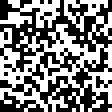

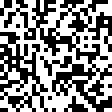

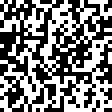

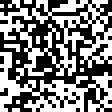

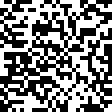

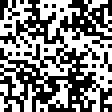

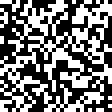

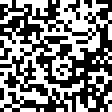

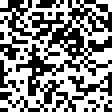

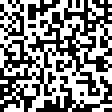

In [8]:
let

    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order 
    for example_image_index ∈ index_vector
    
        ŝₖ = training_image_dataset[example_image_index]; # raw state *not* scaled to -1,1
        s = Array{Int32,1}(undef, number_of_pixels); # initialize some space
        for i ∈ 1:number_of_pixels
            pixel =  ŝₖ[i] |> x-> round(Int,x); # why do we have to round here?
            if pixel == 0.0
                s[i] = -1
            else
                s[i] = 1;
            end
        end
        display(decode(s) |> img -> Gray.(img))
    end
end

### Encode a Hopfield model
Now that we have the training images let's encode the model. We'll compute the weights and the bias term and store them [in an instance of the `MyClassicalHopfieldNetworkModel` type](src/Types.jl). The weights are stored in the `W` field, and the bias term is stored in the `b` field. 

> __How do we build this model__? We build the model (and estimate the weight matrix and bias vector) using [the `build(...)` method](src/Factory.jl). This method takes the type of thing we want to construct, namely [a `MyClassicalHopfieldNetworkModel` instance](src/Types.jl), and the memories we want to encode. The (vectorized) memories are stored in the columns of an array. The [`build(...)` method](src/Compute.jl) returns a model instance with the `W` and `b` fields populated.

Let's store the encoded model in the `model::MyClassicalHopfieldNetworkModel` variable.

In [9]:
model = let

    # initialize -
    number_of_images_to_learn = length(image_index_set_to_encode);
    linearimagecollection = Array{Int32,2}(undef, number_of_pixels, number_of_images_to_learn); # images on columns
    
    # turn our set into a sorted vector -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order 
    for k ∈ eachindex(index_vector)
        
        j = index_vector[k];
        ŝₖ = training_image_dataset[j]; # raw state *not* scaled to -1,1

        # fill the columns of the array -
        for i ∈ 1:number_of_pixels
            pixel =  ŝₖ[i] |> x-> round(Int,x);
            if pixel == 0.0 # hmmm
                linearimagecollection[i,k] = -1;
            else
                linearimagecollection[i,k] = 1;
            end
        end
    end

    # build the model using the encode function -
    model = build(MyClassicalHopfieldNetworkModel, (
        memories = linearimagecollection,
    ));

    # return -
    model
end;

___

## Task 2: Retrieve a memory from the network
In this task, we will retrieve a memory from the Hopfield network starting from a random state vector $\mathbf{s}_{\circ}$. Let's start by specifying which of the images we expect to recover in the `imageindextorecover::Int` variable.

In [10]:
imageindextorecover = 1; # which element of the index vector will we choose?

For comparison purposes later, what is the energy of the true image? Let's look it up from the model's energy dictionary and store it in the `true_image_energy::Float32` variable.

In [11]:
true_image_energy = model.energy[imageindextorecover]

-390.4209f0

Next, we'll build a corrupted initial condition vector $\mathbf{s}_{\circ}$ based on a selected memorized image. This vector will serve as the starting point for the memory recovery algorithm. We initialize the state vector by converting each pixel to the binary scale $\{-1, 1\}$ and then systematically corrupt a fraction of the pixels to simulate noisy input.

> __The $\theta$ corruption parameter:__ The parameter $\theta \in [0,1]$ controls the fraction of pixels we preserve from the original image. Specifically, we keep the first $\theta\cdot{N}$ pixels from the correct image and set the remaining $(1-\theta)\cdot{N}$ pixels to $-1$, simulating damage or noise in the input. For example, if $\theta = 0.5$, we preserve 50% of the original pixel values and corrupt the remaining 50%, creating a noisy version of the true image that the network must restore.

Let's compute the corrupted initial condition vector `sₒ::Array{Int32,1}`.

In [12]:
sₒ = let

    # initialize -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order
    index_of_image_to_encode = index_vector[imageindextorecover]; # -or- choose random
    ŝₖ = training_image_dataset[index_of_image_to_encode]; # raw state *not* scaled to -1,1
    sₒ = Array{Int32,1}(undef, number_of_pixels); # initialize some space
    θ = 0.68; # fraction of pixels that we want to keep correct. This means ~32% corruption, providing a challenging but not impossible recovery task

    # let's build the corrupted initial condition -
    for i ∈ 1:number_of_pixels
        pixel =  ŝₖ[i] |> x-> round(Int,x); # We have some gray-scale values in the original vector, need to round
        if pixel == 0.0
            sₒ[i] = -1;
        else
            sₒ[i] = 1;
        end
    end

    # # cut 1 - θ fraction of the pixels, replacewith - 1
    number_of_pixels_to_corrupt = round(Int, (1 - θ)*number_of_pixels);
    start =(number_of_pixels - number_of_pixels_to_corrupt) + 1;
    for i ∈ start:number_of_pixels
        sₒ[i] = -1;
    end

    sₒ # return
end;

What does the initial state vector $\mathbf{s}_{\circ}$ look like (this should be a corrupted version of the `imageindextorecover::Int` image):

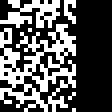

In [13]:
decode(sₒ) |> img -> Gray.(img) # corrupted true image. This is what we give the network
#random change

___

### Run the recovery algorithm
Now that we have a corrupted initial state $\mathbf{s}_{\circ}$, can the network recover the original image?

> __Expected behavior:__ The asynchronous update algorithm iteratively minimizes the network energy by randomly selecting neurons and updating their states based on the activation function. At each step, we record the network state and compute its energy. The algorithm should converge toward the memorized pattern by finding a state that corresponds to a local energy minimum. We expect the energy to generally decrease (or stabilize) as the network evolves from the noisy initial state toward a stored memory pattern.

The recovery algorithm has been implemented in [the `recover(...)` method](src/Compute.jl). This method accepts:
- `model::MyClassicalHopfieldNetworkModel`: The encoded Hopfield network with learned weights
- `sₒ::Array{Int32,1}`: The corrupted initial state vector
- `true_image_energy::Float32`: The energy of the target memorized pattern (for reference)
- `maxiterations::Int64`: Maximum number of update steps to perform (optional: default is `1000`)
- `patience::Union{Int,Nothing}`: Number of consecutive identical states required to declare convergence (optional: default is `5` or greater)
- `miniterations_before_convergence::Union{Int,Nothing}`: minimum updates to run before checking convergence. If `nothing`, defaults to `patience`.

The method returns:
- `frames::Dict{Int64, Array{Int32,1}}`: A dictionary mapping iteration index to the network state at that iteration
- `energydictionary::Dict{Int64, Float32}`: A dictionary mapping iteration index to the network energy at that iteration

Call [the `recover(...)` method](src/Compute.jl) below to perform memory retrieval from the corrupted initial state.

In [14]:
frames, energydictionary = recover(model, sₒ, true_image_energy, maxiterations=25*number_of_pixels, 
    patience = number_of_pixels);

Which image does the model recover? The code block below displays the true image (top), the corrupted initial image (middle), and the recovered image (bottom).

> __Check:__ 
> 
> To evaluate the quality of the recovered image, we can compute the Hamming distance between the recovered state and the true image. The Hamming distance quantifies the number of differing pixels, providing a measure of retrieval accuracy. A lower Hamming distance indicates a closer match to the original image. If the Hamming distance is zero, it means the recovered image exactly matches the true image.
> 
> We check if the Hamming distance between the recovered image and the true image is less than the Hamming distance between the corrupted image and the true image. If it is, no error is thrown; otherwise, an error is raised indicating that the recovery was unsuccessful.

So what do we get?

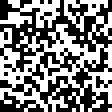

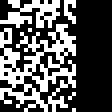

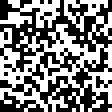

Hamming (best vs true) = 0
Hamming (initial vs true) = 119
Best energy = -390.4209
True energy = -390.4209


In [15]:
let

    # initialize -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order
    my_index_of_image_to_encode = index_vector[imageindextorecover]; # -or- choose random

    # true image -
    ŝₖ = training_image_dataset[my_index_of_image_to_encode]; # raw state *not* scaled to -1,1
    s₁ = Array{Int32,1}(undef, number_of_pixels); # initialize some space
    for i ∈ 1:number_of_pixels
        pixel =  ŝₖ[i] |> x-> round(Int,x); # why do we have to round here?
        if pixel == 0.0
            s₁[i] = -1
        else
            s₁[i] = 1;
        end
    end
    true_image = decode(s₁); # this is the true image
    initial_image = decode(sₒ); # initial corrupted image
    
    # recovered image -
    ks = collect(keys(energydictionary))
    best_key = argmin(k -> energydictionary[k], ks)
    best_state = frames[best_key]
    recovered_image = decode(best_state)

    display(true_image |> img -> Gray.(img))
    display(initial_image |> img -> Gray.(img))
    display(recovered_image |> img -> Gray.(img))

    println("Hamming (best vs true) = ", hamming(best_state, s₁))
    println("Hamming (initial vs true) = ", hamming(sₒ, s₁))
    println("Best energy = ", energydictionary[best_key])
    println("True energy = ", true_image_energy)

    # check: the hamming distance between the best and true should be less than that between the initial and true
    @assert hamming(best_state, s₁) < hamming(sₒ, s₁) "Error: Hamming distance check failed!"
end;

Does the energy decrease as we flip the states in the network? Let's plot the values in the `energydictionary::Dict{Int64, Float32}` and see.

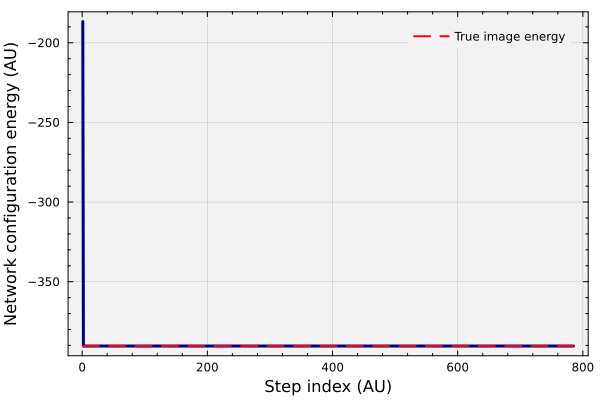

In [16]:
let
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); 
    plot!(energydictionary, lw=3, c=:navy, label="", xminorticks=true, yminorticks=true);
   
    # plot true energy line -
    TEL = true_image_energy*ones(length(energydictionary));
    plot!(TEL, lw=2, c=:red, label="True image energy", ls=:dash);
    xlabel!("Step index (AU)", fontsize=18)
    ylabel!("Network configuration energy (AU)", fontsize=18)
end

___

## Summary
This practicum explores encoding and retrieving multiple binary patterns from classical Hopfield networks using Hebbian learning and energy-based optimization.

> __Key Takeaways:__
> 
> * **Hebbian learning for memory storage:** The network weights encode stored patterns through an outer product sum of memories, allowing direct computation of weights without iterative training. This biological learning mechanism enables unsupervised memory formation based on co-activation patterns.
> * **Energy minimization for pattern recovery:** Memory retrieval operates by iteratively updating neuron states to minimize network energy, allowing the algorithm to recover stored patterns from corrupted or noisy initial conditions through local computations.
> * **Storage capacity limits:** Classical Hopfield networks can reliably store approximately 14% of their neuron count in distinct patterns before interference between memories degrades retrieval performance. This fundamental capacity constraint reflects a trade-off between network size and memory density.

Hopfield networks demonstrate how local learning rules and energy functions can implement associative memory, providing a foundation for understanding recurrent neural network dynamics and constrained optimization in neural systems.

___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [17]:
@testset verbose = true "CHEME 5800 Practicum Test Suite" begin

    @testset "Setup, Data, and Prerequisites" begin
        # Test basic constants
        @test number_of_pixels == number_of_rows * number_of_cols
        @test Kmax ≈ 0.138 * number_of_pixels atol=1  # approximate due to rounding
        @test number_of_training_examples > 0
        @test length(number_digit_array) > 0  # should have some digits
        @test 0 < number_of_images_to_memorize <= Kmax
        
        # Test data loading
        @test !isempty(training_image_dataset)
    end

    @testset "Task 1: Learn the Weights of the Network" begin
        # Test image selection
        @test length(image_index_set_to_encode) == number_of_images_to_memorize
        @test isa(image_index_set_to_encode, Set)
        @test all(1 .<= collect(image_index_set_to_encode) .<= length(training_image_dataset))
        
        # Test model properties
        @test size(model.W) == (number_of_pixels, number_of_pixels)
        @test model.W ≈ model.W'  # weight matrix should be symmetric
        @test all(iszero, model.b)  # bias should be zero for classical Hopfield
        @test all(iszero, diag(model.W))  # no self-connections
        @test length(model.energy) == number_of_images_to_memorize
    end

    @testset "Task 2: Retrieve a Memory from the Network" begin
        # Test recovery process
        energy_keys = collect(keys(energydictionary))
        initial_key = minimum(energy_keys)
        initial_energy = energydictionary[initial_key]
        final_energy = minimum(values(energydictionary))
        @test final_energy <= initial_energy  # energy should not increase
        @test length(frames) > 1  # should have run some iterations
        @test keys(frames) == keys(energydictionary)  # same keys
        
        # Test best state - all states should be binary (from Hopfield network)
        best_key = argmin(k -> energydictionary[k], energy_keys)
        best_state = frames[best_key]
        @test all(s -> abs(s) == 1, best_state)  # binary states (either +1 or -1)
    end

end;

Test Summary:                                | Pass  Total  Time
CHEME 5800 Practicum Test Suite              |   18     18  0.7s
  Setup, Data, and Prerequisites             |    6      6  0.4s
  Task 1: Learn the Weights of the Network   |    8      8  0.3s
  Task 2: Retrieve a Memory from the Network |    4      4  0.1s
